In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


**Part I - Brief Intro / Libraries<br>
Part II - Variables <br>
Part III - Visualizations<br>
Part IV - Clustering (KMeans and Hierarchical)<br>
Part V - Centroids and Profiling<br>**

# Part I - Brief Intro / Libraries
As described in the dataset description the main goal is to use the supermarket data to find customer clusters. After finding specific clusters, the company can run personalized campaigns targeting each group. <br>
The notebook will first go through some basic descriptive statistics about the variables and later the clusters will be developed. The methods used are KMeans and Hierarchical Clustering.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as sch
mall=mall = pd.read_csv("../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Part II - Variables
$First$ $glance$ $at$ $variables:$ <br>
Theses are initial thoughts, for further details check the table and charts below.<br>
$Age$<br>
Age ranges between 18 and 70 years with an average of 38.85 and median of 36. The distribution roughly shows more people of younger ages and less people as age increases. <br>
$Income$<br>
Income ranges between 15k and 137k with an average of 60.56 and median of 61.50. The distribution shows that very few people have a large amount of income (>100k) and most of people earning between 40k and 90k.<br>
$Spending Score$ <br>
Spending score distribution seems to be more symmetric with an average of 50.2 and median of 50. It resembles more a normal curve.<br>
$Gender$ <br>
Gender is distributed as 56% females and 44% males.

In [3]:
print(mall.shape)
mall.describe()

(200, 5)


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


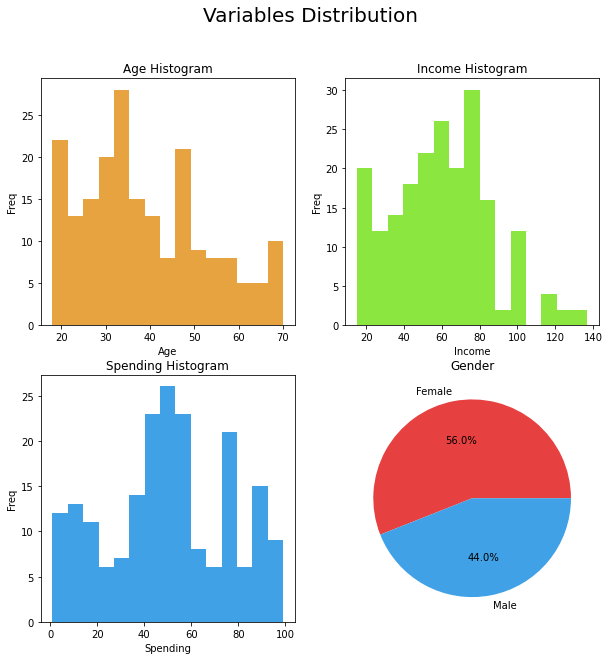

In [4]:
# Distributions - Age, Income and Spending Score

# General fig
fig, axs =plt.subplots(2,2,figsize=(10,10))

#Age
axs[0,0].hist(mall['Age'],bins=15,color='#e6a340')
axs[0,0].set_title('Age Histogram')
axs[0,0].set_xlabel('Age')
axs[0,0].set_ylabel('Freq')

# Income
axs[0,1].hist(mall["Annual Income (k$)"],bins=15,color='#8be640')
axs[0,1].set_title('Income Histogram')
axs[0,1].set_xlabel('Income')
axs[0,1].set_ylabel('Freq')

# Spending
axs[1,0].hist(mall["Spending Score (1-100)"],bins=15,color='#40a1e6')
axs[1,0].set_title('Spending Histogram')
axs[1,0].set_xlabel('Spending')
axs[1,0].set_ylabel('Freq')

# Gender
# First creating a table to summarize information
gender_sum=mall.groupby(['Gender']).Gender.count().to_frame('Count').reset_index()
axs[1,1].pie(gender_sum.Count,labels=gender_sum.Gender,autopct='%1.1f%%',colors=('#e64040','#40a1e6'))
axs[1,1].set_title('Gender')

# General Title
fig.suptitle('Variables Distribution',size=20)
plt.show()

#  Part III - Visualizations
In this section, was to plot some combination of variables to see if there was any pattern, correlation, or difference between genders. In this case, there was no difference between women and men in terms of age, income, and spending score distribution. They are essentially the same. For "age x income" and "age x spending score" there is no apparent correlation. However, between "income x spending score" it seems that there are some observable groups forming a "X".<br>
Something that I found curious was the positive correlation between Customer_ID and income. In my opinion, this relation should not be observable since Customer_ID is only used to identify a customer.


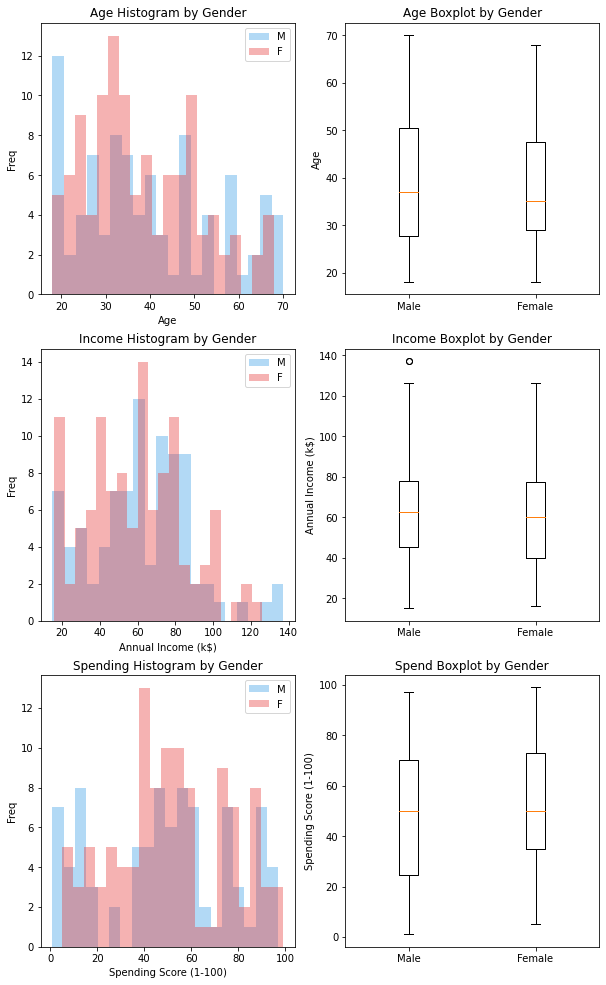

In [5]:
# The big figure
fig, axs =plt.subplots(3,2,figsize=(10,17))

# Age
# Age - histogram by gender
metric="Age"
axs[0,0].hist(mall.query("Gender == 'Male'")[metric],alpha=0.4, bins=20, label='M',color='#40a1e6')
axs[0,0].hist(mall.query("Gender == 'Female'")[metric],alpha=0.4, bins=20,label='F',color='#e64040')
axs[0,0].set_title('Age Histogram by Gender')
axs[0,0].set_xlabel(metric)
axs[0,0].set_ylabel('Freq')
axs[0,0].legend()

# Age - Boxplot by gender
age_boxplot=[mall.query("Gender == 'Male'")[metric],
             mall.query("Gender == 'Female'")[metric]]
axs[0,1].boxplot(age_boxplot)
axs[0,1].set_xticklabels(['Male','Female'])
axs[0,1].set_ylabel(metric)
axs[0,1].set_title('Age Boxplot by Gender')


#############################################################
# Income
#Income - histogram by gender
metric="Annual Income (k$)"
axs[1,0].hist(mall.query("Gender == 'Male'")[metric],alpha=0.4, bins=20, label='M',color='#40a1e6')
axs[1,0].hist(mall.query("Gender == 'Female'")[metric],alpha=0.4, bins=20,label='F',color='#e64040')
axs[1,0].set_title('Income Histogram by Gender')
axs[1,0].set_xlabel(metric)
axs[1,0].set_ylabel('Freq')
axs[1,0].legend()

# Income - boxplot by gender
income_boxplot=[mall.query("Gender == 'Male'")[metric],
             mall.query("Gender == 'Female'")[metric]]
axs[1,1].boxplot(income_boxplot)
axs[1,1].set_xticklabels(['Male','Female'])
axs[1,1].set_ylabel(metric)
axs[1,1].set_title('Income Boxplot by Gender')
##############################################################
# Spending Score
# Spending Score - histogram by gender
metric="Spending Score (1-100)"
axs[2,0].hist(mall.query("Gender == 'Male'")[metric],alpha=0.4, bins=20, label='M',color='#40a1e6')
axs[2,0].hist(mall.query("Gender == 'Female'")[metric],alpha=0.4, bins=20,label='F',color='#e64040')
axs[2,0].set_title('Spending Histogram by Gender')
axs[2,0].set_xlabel(metric)
axs[2,0].set_ylabel('Freq')
axs[2,0].legend()

# Spending Score - boxplot by gender
spend_boxplot=[mall.query("Gender == 'Male'")[metric],
             mall.query("Gender == 'Female'")[metric]]
axs[2,1].boxplot(spend_boxplot)
axs[2,1].set_xticklabels(['Male','Female'])
axs[2,1].set_ylabel(metric)
axs[2,1].set_title('Spend Boxplot by Gender')

#plot the figure
plt.show()

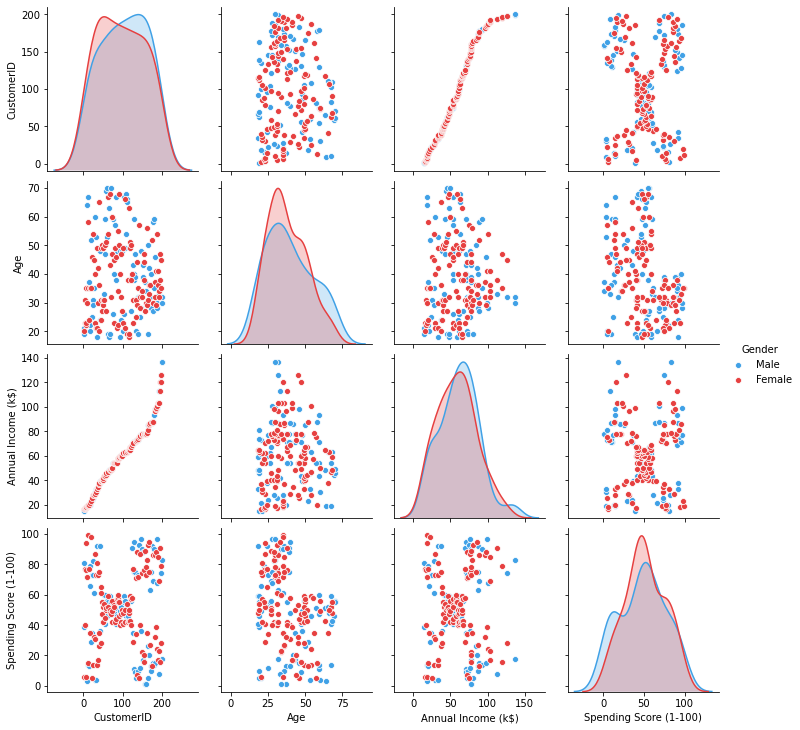

In [6]:
sns.pairplot(mall,kind='scatter',hue='Gender',palette=('#40a1e6','#e64040'))
plt.show()

# Part IV - Clustering
This section is the main focus of the notebook. Here we will be comparing 2 clusters methodologies: KMeans and Hierarchical Clustering. <br>
For this dataset both approaches generate very similar results with almost no difference between them.


### K Means
Before finding the optimal number of clusters, I arbitrarily set n_clusters as 3 just to have a rough idea how the algorithm would group the customers. With n_clusters = 3 the clustering is not bad (figure below), however it can be improved...  

In [7]:
# First, just guessing a number of clusters

# Including gender as a dummy variable
mall['Gender_2']=mall['Gender'].apply(lambda x: 1 if x=='Male' else 0)

#running kmeans with 3 clusters
variables=mall[['Age','Annual Income (k$)','Spending Score (1-100)','Gender_2']]
model_kmeans=KMeans(n_clusters=3)
model_kmeans.fit(variables)

KMeans(n_clusters=3)

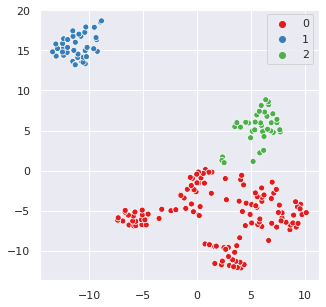

In [8]:
# getting a 2D approximation for the clusters
# plot the clusters
tsne=TSNE()
visualization=tsne.fit_transform(variables)
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x=visualization[:,0],y=visualization[:,1],
               hue=model_kmeans.labels_,
               palette=sns.color_palette('Set1',3))
plt.show()

To improve the above clustering, I used the "elbow method" and found that six clusters would be reasonable. <br>
(I also tried wih 5 clusters, but in my personal opinion 6 resulted in a better segmentation).<br><br>


"elbow method" - In a nutshell, is the point where any additional cluster does not significantly decrease the error/variation.

In [9]:
# Figuring out the optimal number of clusters
# The idea will be running KMeans with different numbers of clusters
# and compute the error associated with it
# We will be using the elbow method to determine the exact number of clusters

# First define a function that returns the number of clusters and error

def k_means_elbow(n_clust,variables):
    model_kmeans=KMeans(n_clusters=n_clust)
    model_kmeans.fit(variables)
    return [n_clust,model_kmeans.inertia_]

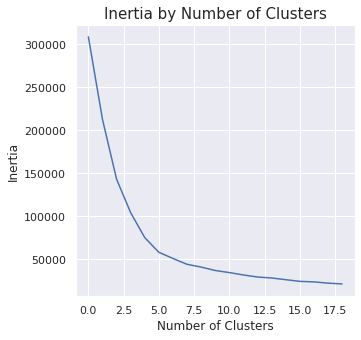

In [10]:
#plot Inertia by number of clusters
elbow=[k_means_elbow(n_cluster,variables) for n_cluster in range (1,20)]
elbow=pd.DataFrame(elbow,columns=['n_clusters','Inertia'])
plt.figure(figsize=(5,5))
elbow['Inertia'].plot()
plt.title('Inertia by Number of Clusters',size=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Same code, but 6 clusters instead of 3

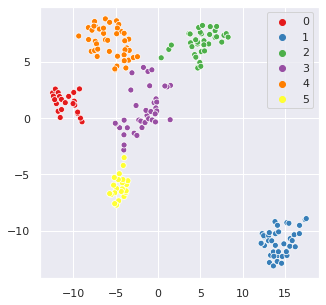

In [11]:
# repeat the previous process again but with n_cluters=5
variables=mall[['Age','Annual Income (k$)','Spending Score (1-100)','Gender_2']]
n_clust=6
model_kmeans=KMeans(n_clusters=n_clust)
model_kmeans.fit(variables)

# Including the cluster classification in the dataframe
predict=model_kmeans.predict(variables)
mall['kmeans_6']=pd.Series(predict,index=mall.index)

tsne=TSNE()
visualization=tsne.fit_transform(variables)
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x=visualization[:,0],y=visualization[:,1],
               hue=model_kmeans.labels_,
               palette=sns.color_palette('Set1',n_clust))
plt.show()

### Hierarchical Clustering
Using the hierarchical clustering and dendrogram, we can see how the algorithm is grouping all data points by proximity, starting from 200 cluster (each data point is a cluster) and reaching 1 (all data points in a single cluster). Six clusters also seem to be reasonable. <br>
The next section will show the differences between both methods.


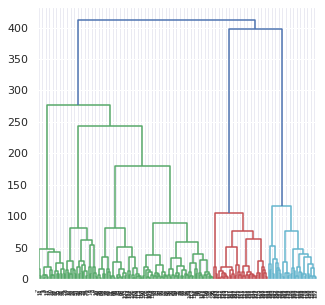

In [12]:
dendrogram=sch.dendrogram(sch.linkage(variables,method='ward'))

In [13]:
variables=mall[['Age','Annual Income (k$)','Spending Score (1-100)','Gender_2']]
n_clust=6
model_HC=AgglomerativeClustering(n_clusters=n_clust, affinity='euclidean',linkage='ward')
groups_HC=model_HC.fit_predict(variables)
groups_HC
mall['HC_6']=pd.Series(groups_HC,index=mall.index)

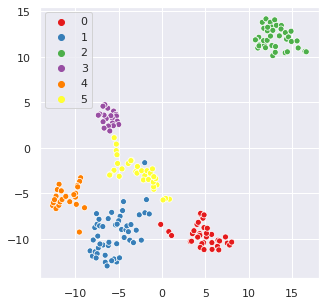

In [14]:
tsne=TSNE()
visualization=tsne.fit_transform(variables)
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x=visualization[:,0],y=visualization[:,1],
               hue=model_HC.labels_,
               palette=sns.color_palette('Set1',n_clust))
plt.show()

### Comparison between KMeans and Hierarchical Clustering
In this case both methods result in very similar clusters. There are only very few exceptions. <br>

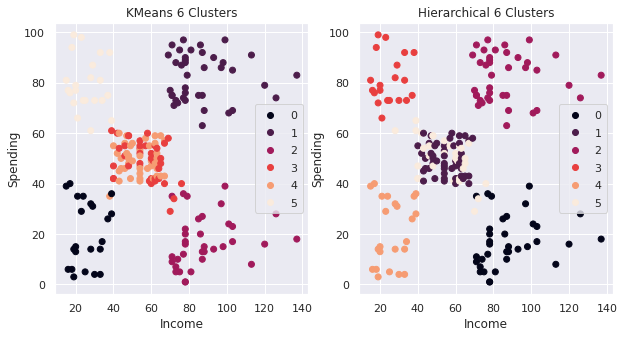

In [15]:
fig, axs =plt.subplots(1,2,figsize=(10,5))

#kmeans plot
a=axs[0].scatter(x=mall["Annual Income (k$)"],y=mall["Spending Score (1-100)"],c=mall['kmeans_6'])
axs[0].legend(*a.legend_elements())
axs[0].set_title('KMeans 6 Clusters')
axs[0].set_xlabel('Income')
axs[0].set_ylabel('Spending')

#HC plot
b=axs[1].scatter(x=mall["Annual Income (k$)"],y=mall["Spending Score (1-100)"],c=mall['HC_6'])
axs[1].legend(*b.legend_elements())
axs[1].set_title('Hierarchical 6 Clusters')
axs[1].set_xlabel('Income')
axs[1].set_ylabel('Spending')

plt.show()

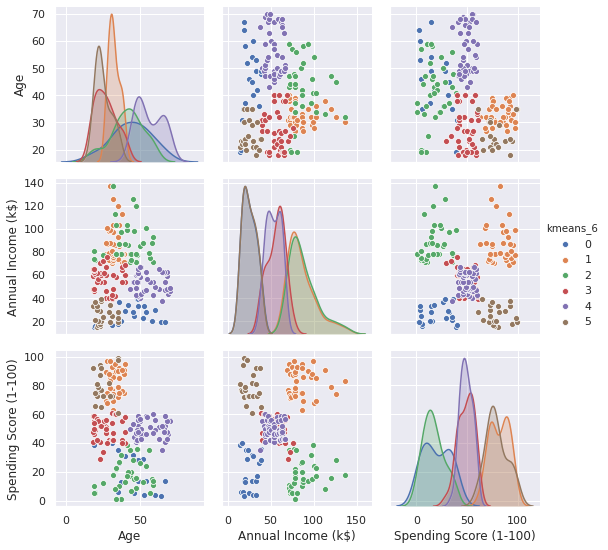

In [16]:
#Pair plot
sns.pairplot(mall[['Age','Annual Income (k$)','Spending Score (1-100)','kmeans_6']],kind='scatter',hue='kmeans_6')
plt.show()

# Part V - Centroids and Profiling
In overall, Spending Score and Income can pretty much divide almost all groups. 1 group per "corner" in the chart, totaling 4 (groups 0,2,3,4) and 2 groups (1 and 5) in the middle.<br> <br>
$group$ $1$ $and$ $5$ - have the same income and spending score. The main differences are on the age, group 1 is younger (27 years) vs group 5 older (56 years) and on gender proportion, group 0 (34.21% men) and group 2 (44.44% men).<br>
$group$ $0$ - seems to be the most valuable customer, since they have a high spending score (82.12) and high income (86.53k). Average age of 32 years. <br>
$group$ $4$ - is also valuable. Despite their significant lower income (25.72k), they still have high spending scores (79.36). Average age of 25 years. (could be young early career professionals). <br>
$group$ $3$ - have the highest potential for gain since they have the highest level of income (88.22k) , but the lowest spending score (17.28). Could be an interesting group to run a campaign. Average age of 41 years. <br>
$group$ $2$ - Seems to be least interesting group to target. They have the lowest income (25.14k) and the second lowest spending score (19.52). Perhaps there are some products that can increase the spending score of this group. Average age of 44 years.


In [17]:
variables=mall[['Age','Annual Income (k$)','Spending Score (1-100)','Gender_2']]
summary_centroids=pd.DataFrame(model_kmeans.cluster_centers_,columns=variables.columns)
summary_centroids

,Age,Annual Income (k$),Spending Score (1-100),Gender_2
0,44.318182,25.772727,20.272727,0.409091
1,32.692308,86.538462,82.128205,0.461538
2,41.685714,88.228571,17.285714,0.571429
3,27.000000,56.657895,49.131579,0.342105
4,56.340909,53.704545,49.386364,0.431818
5,25.272727,25.727273,79.363636,0.409091
